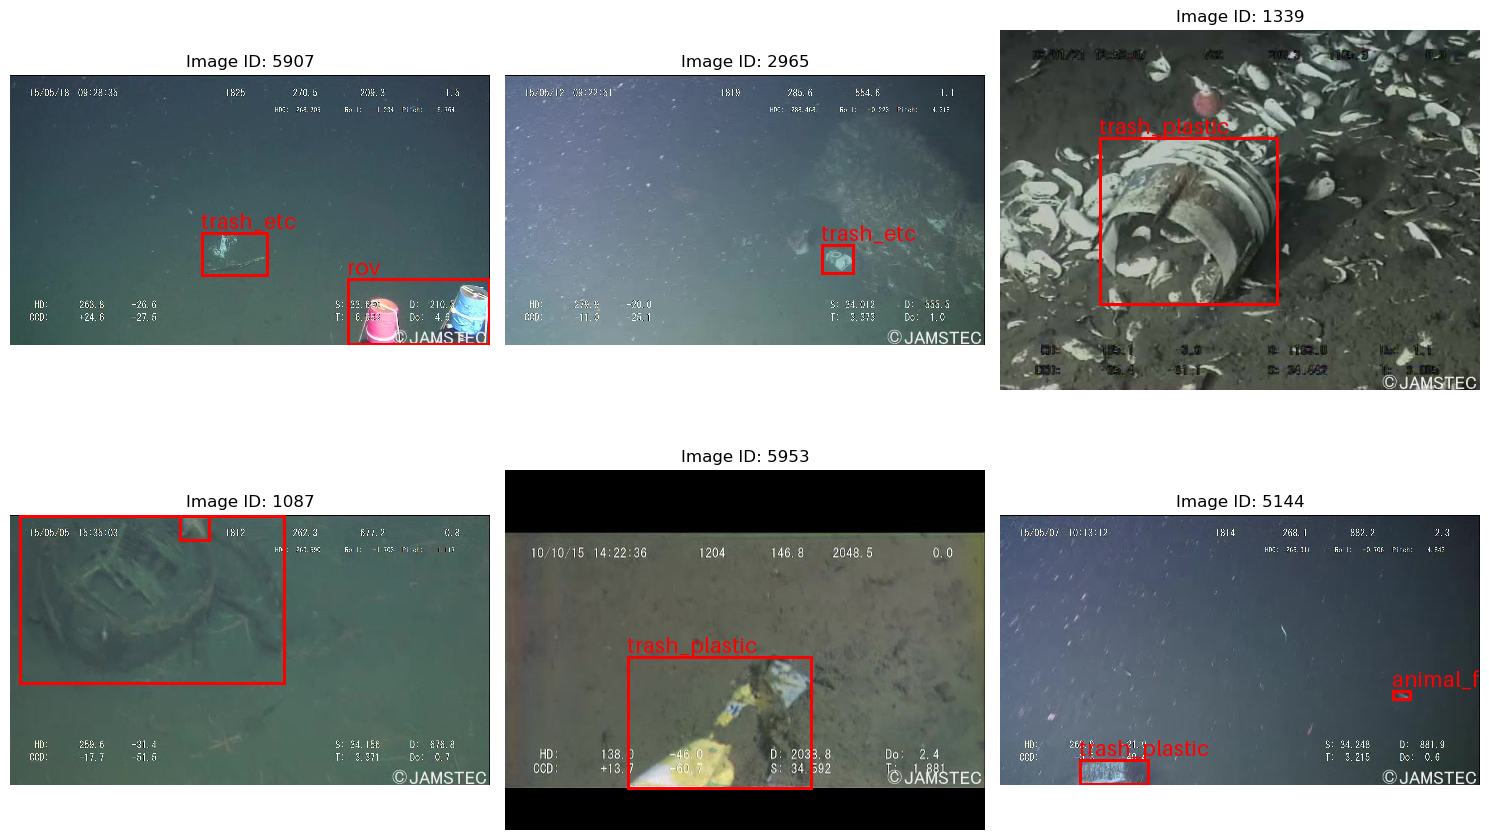

In [2]:
import json
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

# Paths to your dataset
image_folder = "dataset/material_version/train/"
annotations_file = "dataset/material_version/instances_train_trashcan.json"

# Load the annotations
with open(annotations_file, "r") as f:
    data = json.load(f)

# Load the images and annotations
images = data["images"]
annotations = data["annotations"]

id_to_name = {category["id"]: category["name"] for category in data["categories"]}

# Create a mapping from image_id to its annotations
image_to_annotations = {}
for annotation in annotations:
    image_id = annotation["image_id"]
    if image_id not in image_to_annotations:
        image_to_annotations[image_id] = []
    image_to_annotations[image_id].append(annotation)

# Select six images to display
selected_images = random.sample(images, 6)

# Plot the images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Set up the font for drawing text
font = ImageFont.load_default(
    size=22
)  # Fallback to default font if TrueType font is not available

for idx, img_info in enumerate(selected_images):
    image_id = img_info["id"]
    image_path = os.path.join(image_folder, img_info["file_name"])

    # Open the image
    img = Image.open(image_path)

    # Draw the bounding boxes
    draw = ImageDraw.Draw(img)
    if image_id in image_to_annotations:
        for annotation in image_to_annotations[image_id]:
            bbox = annotation["bbox"]  # [x, y, width, height]
            x, y, w, h = bbox
            draw.rectangle([x, y, x + w, y + h], outline="red", width=3)

            # Add the class name with a larger font
            category_id = annotation["category_id"]
            category = id_to_name[category_id]
            draw.text(
                (x, y - 25), category, fill="red", font=font
            )  # Adjust vertical offset for visibility

    # Display the image
    axes[idx].imshow(img)
    axes[idx].set_title(f"Image ID: {image_id}")
    axes[idx].axis("off")

# Hide unused subplots
for ax in axes[len(selected_images) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [17]:
import os
import json
from PIL import Image
from tqdm import tqdm
import random

# Paths to your dataset
base_folder = "dataset/material_version/"
image_folders = {"train": os.path.join(base_folder, "train/"),
                 "val": os.path.join(base_folder, "val/")}
annotations_files = {"train": os.path.join(base_folder, "instances_train_trashcan.json"),
                     "val": os.path.join(base_folder, "instances_val_trashcan.json")}
output_folder = "dataset_cropped/"

# Create output directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(output_folder, split), exist_ok=True)

# Function to generate adjusted crop boxes
def generate_loose_bboxes(bbox, img_width, img_height):
    x, y, w, h = bbox
    case = random.choices(
        [1, 2, 3, 4, 5],
        weights=[15, 20, 45.5, 16.25, 8.25],
        k=1
    )[0]

    if case == 1:  # 15% exact bounding box
        left, top, right, bottom = int(x), int(y), int(x + w), int(y + h)

    elif case == 2:  # 20% margin 0% to 10% in all directions
        margin_x = int(w * random.uniform(0, 0.1))
        margin_y = int(h * random.uniform(0, 0.1))
        left = max(0, x - margin_x)
        top = max(0, y - margin_y)
        right = min(img_width, x + w + margin_x)
        bottom = min(img_height, y + h + margin_y)

    elif case == 3:  # 45.5% margin up to 25%
        margin_x = int(w * random.uniform(0, 0.25))
        margin_y = int(h * random.uniform(0, 0.25))
        left = max(0, x - margin_x)
        top = max(0, y - margin_y)
        right = min(img_width, x + w + margin_x)
        bottom = min(img_height, y + h + margin_y)

    elif case == 4:  # 16.25% one larger side margin
        large_margin = random.uniform(0.5, 1.2)
        small_margin = random.uniform(0, 0.05)
        side = random.choice(["horizontal", "vertical"])

        if side == "horizontal":
            margin_x = int(w * large_margin)
            margin_y = int(h * small_margin)
        else:
            margin_x = int(w * small_margin)
            margin_y = int(h * large_margin)

        left = max(0, x - (margin_x if side == "horizontal" else 0))
        top = max(0, y - (margin_y if side == "vertical" else 0))
        right = min(img_width, x + w + (margin_x if side == "horizontal" else 0))
        bottom = min(img_height, y + h + (margin_y if side == "vertical" else 0))

    elif case == 5:  # 8.25% both sides large margins
        margin_x = int(w * random.uniform(0.3, 0.7))
        margin_y = int(h * random.uniform(0.3, 0.7))
        left = max(0, x - margin_x)
        top = max(0, y - margin_y)
        right = min(img_width, x + w + margin_x)
        bottom = min(img_height, y + h + margin_y)

    return (int(left), int(top), int(right), int(bottom))

# Process each dataset (train/val)
for split, image_folder in image_folders.items():
    annotations_file = annotations_files[split]
    split_output_folder = os.path.join(output_folder, split)

    # Load annotations
    with open(annotations_file, "r") as f:
        data = json.load(f)

    categories = data["categories"]
    id_to_name = {category["id"]: category["name"] for category in categories}

    # Prepare new annotations
    new_annotations = []

    for img_info in tqdm(data["images"], desc=f"Processing {split} images"):
        image_id = img_info["id"]
        image_path = os.path.join(image_folder, img_info["file_name"])

        if not os.path.exists(image_path):
            continue

        img = Image.open(image_path)
        img_width, img_height = img.size

        # Get annotations for this image
        annotations = [
            ann for ann in data["annotations"] if ann["image_id"] == image_id
        ]

        for ann in annotations:
            category_id = ann["category_id"]
            category_name = id_to_name[category_id]
            bbox = ann["bbox"]

            # Generate loose bounding box
            left, top, right, bottom = generate_loose_bboxes(bbox, img_width, img_height)

            # Crop and save image
            cropped_img = img.crop((left, top, right, bottom))
            cropped_img_name = f"{image_id}_{ann['id']}.jpg"
            cropped_img_path = os.path.join(split_output_folder, cropped_img_name)
            cropped_img.save(cropped_img_path)

            # Update annotation
            new_bbox = [
                bbox[0] - left,
                bbox[1] - top,
                bbox[2],
                bbox[3]
            ]

            new_annotations.append({
                "file_name": os.path.join(split, cropped_img_name),
                "bbox": new_bbox,
                "category_id": category_id,
                "category_name": category_name,
                "split": split
            })

    # Save updated annotations
    output_annotations_file = os.path.join(output_folder, f"instances_{split}.json")
    with open(output_annotations_file, "w") as f:
        json.dump({"annotations": new_annotations}, f, indent=4)

print(f"New dataset created at {output_folder}")


Processing val images: 100%|██████████| 1204/1204 [00:07<00:00, 155.25it/s]


New dataset created at dataset_cropped/


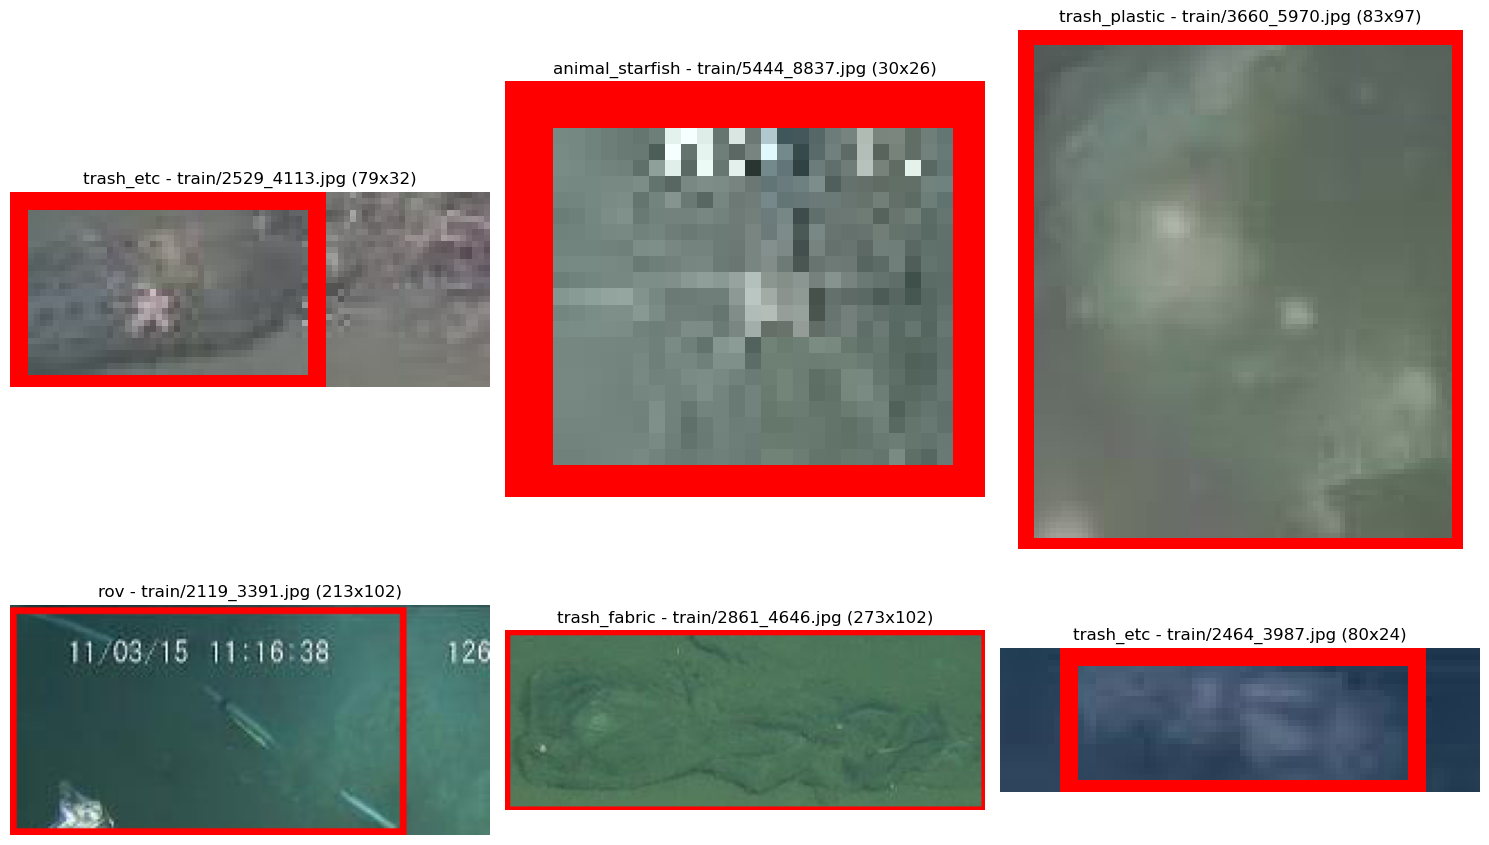

In [23]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

# Path to the cropped dataset
cropped_dataset_folder = "dataset_cropped/"
split = "train"  # Choose "train" or "val"

# Font setup for text
try:
    font = ImageFont.truetype("arial.ttf", size=16)
except IOError:
    font = ImageFont.load_default()

# Load the JSON file for the selected split
json_path = os.path.join(cropped_dataset_folder, f"instances_{split}.json")
with open(json_path, "r") as f:
    annotations = json.load(f)["annotations"]

# Randomly select six annotations to display
selected_annotations = random.sample(annotations, min(6, len(annotations)))

# Plot the images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, annotation in enumerate(selected_annotations):
    img_path = os.path.join(cropped_dataset_folder, annotation["file_name"])
    img = Image.open(img_path)
    img_width, img_height = img.size

    # Draw bounding box
    draw = ImageDraw.Draw(img)
    bbox = annotation["bbox"]
    x, y, w, h = bbox
    draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
    draw.text((x, y - 15), annotation["category_name"], fill="red", font=font)

    # Display the image
    axes[idx].imshow(img)
    axes[idx].set_title(f"{annotation['category_name']} - {annotation['file_name']} ({img_width}x{img_height})")
    axes[idx].axis("off")

# Hide unused subplots
for ax in axes[len(selected_annotations):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

Dataset split: train
Bounding Box Stats:
  Avg. Width: 143.34, Median Width: 92.00
  Avg. Height: 96.31, Median Height: 67.98
Image Size Stats:
  Avg. Width: 172.92, Median Width: 119.00
  Avg. Height: 118.29, Median Height: 87.00


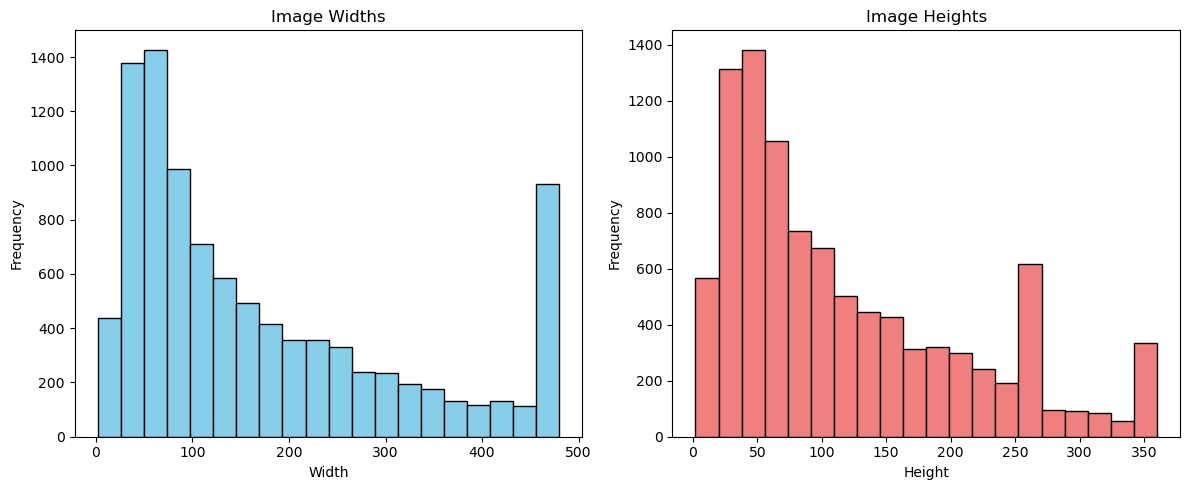

In [9]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to the cropped dataset
cropped_dataset_folder = "dataset_cropped/"
split = "train"  # Choose "train" or "val"

# Load the JSON file for the selected split
json_path = os.path.join(cropped_dataset_folder, f"instances_{split}.json")
with open(json_path, "r") as f:
    annotations = json.load(f)["annotations"]

# Initialize lists for sizes
bbox_widths = []
bbox_heights = []
image_widths = []
image_heights = []

# Process each annotation to collect size metrics
for annotation in annotations:
    img_path = os.path.join(cropped_dataset_folder, annotation["file_name"])
    
    # Extract bounding box dimensions
    bbox = annotation["bbox"]
    bbox_widths.append(bbox[2])  # width
    bbox_heights.append(bbox[3])  # height

    # Extract image dimensions
    img = Image.open(img_path)
    image_widths.append(img.width)
    image_heights.append(img.height)

# Calculate statistics
def compute_stats(values):
    return {
        "mean": np.mean(values),
        "median": np.median(values),
    }

bbox_width_stats = compute_stats(bbox_widths)
bbox_height_stats = compute_stats(bbox_heights)
image_width_stats = compute_stats(image_widths)
image_height_stats = compute_stats(image_heights)

# Display statistics
print(f"Dataset split: {split}")
print("Bounding Box Stats:")
print(f"  Avg. Width: {bbox_width_stats['mean']:.2f}, Median Width: {bbox_width_stats['median']:.2f}")
print(f"  Avg. Height: {bbox_height_stats['mean']:.2f}, Median Height: {bbox_height_stats['median']:.2f}")
print("Image Size Stats:")
print(f"  Avg. Width: {image_width_stats['mean']:.2f}, Median Width: {image_width_stats['median']:.2f}")
print(f"  Avg. Height: {image_height_stats['mean']:.2f}, Median Height: {image_height_stats['median']:.2f}")

# Generate histograms for image dimensions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(image_widths, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title("Image Widths")
axes[0].set_xlabel("Width")
axes[0].set_ylabel("Frequency")

axes[1].hist(image_heights, bins=20, color='lightcoral', edgecolor='black')
axes[1].set_title("Image Heights")
axes[1].set_xlabel("Height")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()